In [1]:
from neurodsp import sim, spectral
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from fooof import FOOOF
from bycycle.filt import lowpass_filter
from bycycle.features import compute_features
import random
from scipy.stats import truncnorm
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import pandas as pd


os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')
import module_pac_functions as pacf

In [13]:
# parameters
fs = 1000
n_seconds = 32 # if we are gonna use longer signals, original PSD will be stronger so maybe less brown noise
times = create_times(n_seconds, fs)
plt_time =  [0,3000]
signal_length = n_seconds * fs

### Simulate sinusoid of either 5, 10 or 20 Hz

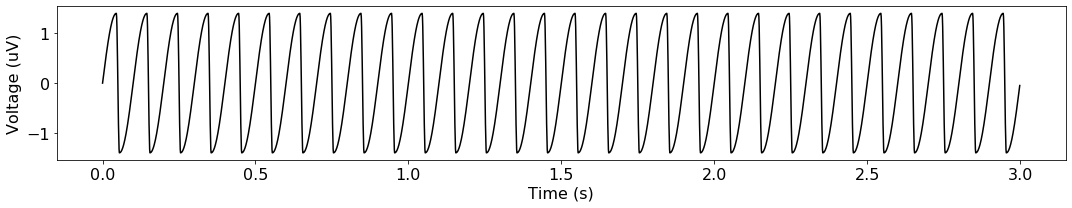

In [21]:
# frequency
freq_list = [10]
# sinusoids or nonsinusoid
lf_waveform = ['sine', 'asine']  
# shape nonsinusoid
lf_rdsym = [.1, .2, .3, .4, .6, .7, .8, .9]


# get frequency
osc_freq_rand = random.choice(freq_list)

# if sinusiod
asine_or_sine = random.choice(lf_waveform)

# simulate sinusoid
if asine_or_sine == 'sine':

    signal = sim.sim_oscillation(n_seconds, fs, osc_freq_rand, cycle='sine')


# or nonsinusoid
elif asine_or_sine == 'asine':

    asine_rdsym = random.choice(lf_rdsym)
    signal = sim.sim_oscillation(n_seconds, fs, osc_freq_rand, cycle='asine' ,rdsym=asine_rdsym)




plot_time_series(times[plt_time[0]:plt_time[1]], signal[plt_time[0]:plt_time[1]])

 <div class="alert alert-danger">
P.S. I create a extra cycle at the beginning and end of signal and cut them off before analysis
</div>

### 'roll' data randomly to not have the same phase in the same place every time

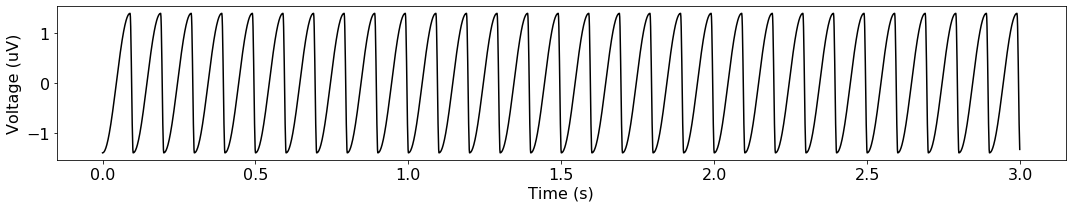

In [22]:
# roll signal to have different phase every simulation
signal = np.roll(signal, random.randint(0,signal_length))

plot_time_series(times[plt_time[0]:plt_time[1]], signal[plt_time[0]:plt_time[1]])

### Add 50x brown noise with a exp between -2 and -1 exponential

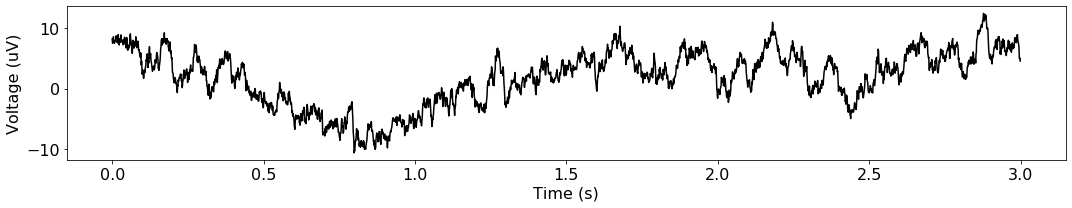

In [23]:
exp = [-2, -1.5]

# get random exponential 
exp_rand = random.uniform(exp[0], exp[1])

# simulate 50x brown noise on top to get reliable slope
n_brown_noise = 50
for br in range(n_brown_noise):
    br_noise = sim.sim_powerlaw(n_seconds, fs, exp_rand)
    signal = signal + br_noise


plot_time_series(times[plt_time[0]:plt_time[1]], signal[plt_time[0]:plt_time[1]])
    
    

 <div class="alert alert-danger">
I add brown noise 50 times, because otherwise there is not a strong, reliable PSD. If this PSD is not so strong, the high frequencies that are added later on have too strong effect and totally change the slope (power in HF's will even be higher in e.g. 30-60Hz range). That is also the reason why I chose a brown noise exp [-2 -1], instead of [-3, -1]. 
</div>

### Select a firing variance, create distribution, and take samples from distribution

Text(0.5, 1.0, 'Distribution with std: 0.29')

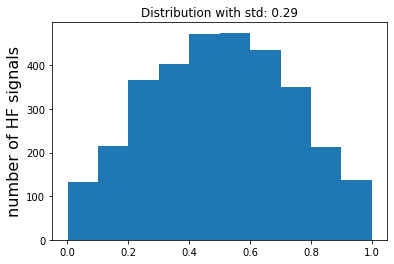

In [24]:
# standard deviations for HG firing distributions
sd_list = np.linspace(5,29,25) / 100
uniform = np.array([1,1,1,1,1])
sd_list = np.append(sd_list, uniform)

# parameters for HG firing distributions 
mean = 0.5 
low_bound = 0
upp_bound = 1

# calculate length cycle
samples_cycle = 1/osc_freq_rand * fs

# calculate number of bursts per cycle - 1000 bursts per second
total_bursts_sec = 1000 * n_seconds
bursts_per_cycle = int(total_bursts_sec / osc_freq_rand)

# randomly select one of the distributions
sd = random.choice(sd_list)

# create distribution function
hf_distribution = truncnorm((low_bound - mean) / sd, (upp_bound - mean) / sd, loc=mean, scale=sd)

# get n samples of distribution corresponding with number of bursts per cycle
hf_distribution_array = hf_distribution.rvs(bursts_per_cycle)

plt.hist(hf_distribution_array)
plt.ylabel('number of HF signals', size=16)
plt.title('Distribution with std: '+ str(sd))

 <div class="alert alert-danger">
So what I basically did here is: create a distribution from 0 to 1 with mean 0.5. And use different standard deviations to simulate really phase-locked activity (std = .01) to basically uniform distribution (std = .64). Stds are because these are exponents of each other, and after trying a few things this seems to work.  
</div>

### Translate distributions to locations of HG activity per cycle (starting with second cycle)

Text(0.5, 0, 'sample in signal')

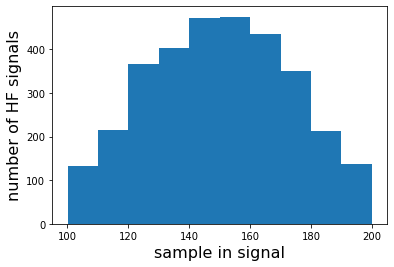

In [25]:
cc = 1

# create array with sample in which each cycle starts
cycle_array = np.linspace(0,signal_length, osc_freq_rand * n_seconds, endpoint=False)

# translate the distributions to each sample were activity is
hf_activity_array = [(cycle_array[cc] + (hf_distribution_array[ii] * samples_cycle)) 
                    for ii in range(len(hf_distribution_array))] 

plt.hist(hf_activity_array)
plt.ylabel('number of HF signals', size=16)
plt.xlabel('sample in signal', size=16)

### One by one simulate the HF activity (random between 80 - 250Hz) and add it to the signal (only show 1 cycle)

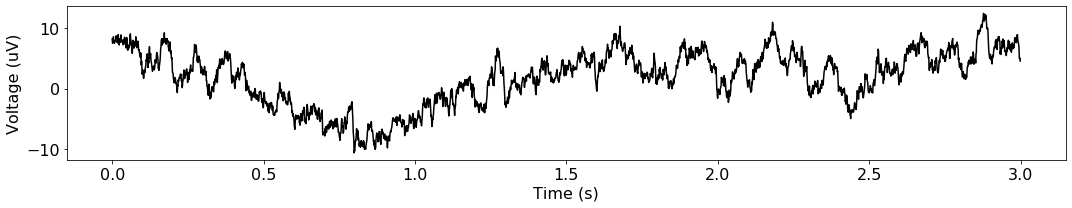

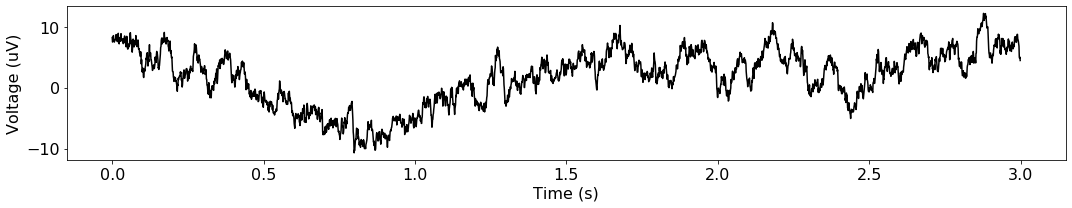

In [26]:
hf_range = [80,250]

plot_time_series(times[plt_time[0]:plt_time[1]], signal[plt_time[0]:plt_time[1]])

# cc = for each cycle 
for cc in range(1,len(cycle_array)-1):

    # 100 samples of the distribution for each cycle in signal
    hf_distribution_array = hf_distribution.rvs(bursts_per_cycle)

    # translate the distributions to each sample were activity is
    hf_activity_array = [(cycle_array[cc] + (hf_distribution_array[ii] * samples_cycle)) 
                        for ii in range(len(hf_distribution_array))]   

    # kk = for each simulated high freq activity
    for kk in range(len(hf_activity_array)):

        # get random high frequency and length of a cycle of that frequency
        hf_freq = random.randint(hf_range[0],hf_range[1])
        n_seconds_cycle = (1/hf_freq * fs)/fs

        # create cycle of high frequency with 0.05 'power'
        hf_cycle = np.sin(2*np.pi*1/n_seconds_cycle * (np.arange(fs*n_seconds_cycle)/fs))*.01

        # add cycles to zeros signal - in the center
        signal[int(round(hf_activity_array[kk]) -  np.ceil(len(hf_cycle) / 2)) : 
            int(round(hf_activity_array[kk]) + np.floor(len(hf_cycle) / 2))] = \
            signal[int(round(hf_activity_array[kk]) -  np.ceil(len(hf_cycle) / 2)) : \
            int(round(hf_activity_array[kk]) + np.floor(len(hf_cycle) / 2))] + hf_cycle

    
plot_time_series(times[plt_time[0]:plt_time[1]], signal[plt_time[0]:plt_time[1]])


 <div class="alert alert-danger">
Here I show: get a distribution for each cycle. For each cycle add a number of HF activities (80 - 250 Hz) to the signal. Second plot shows the added HF's (only not for first cycle, which will be cut off). I used a 'power' of 0.05 (multiplying the HF signal by .05), so it does not have the same strenght as a low-frequency activity and will not dominate the signal.
</div>

### FOOOF it - in some cases still problems with getting a correct 1/f shape after adding HF's 

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 250 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.5320, 1.6114                                          
                                                                                                  
                                       2 peaks were found:                                        
          

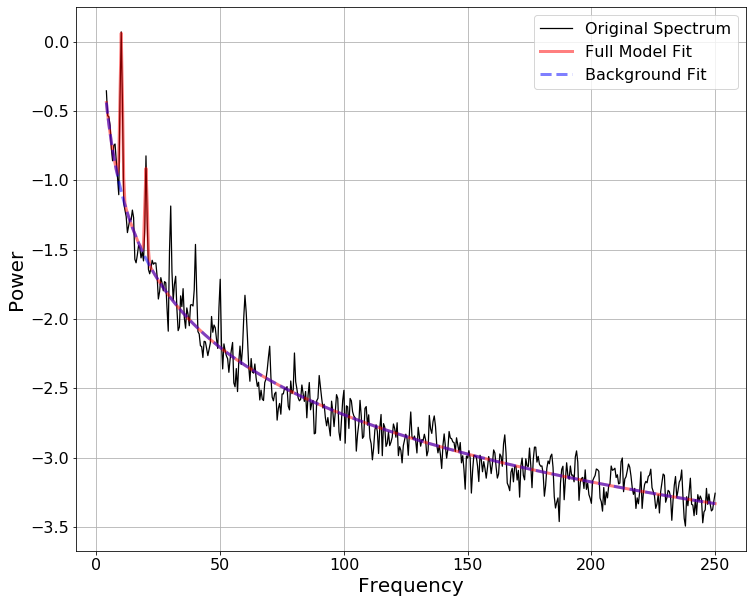

In [27]:
# cut off first and last second of signal
signal = signal[fs*1:-fs*1]

# FOOOF parameters
freq_range = [4, 250] # for peak detection
bw_lims = [1, 2]
max_n_peaks = 2
min_peak_amplitude = .7


# run FOOOF
# compute frequency spectrum
freq_mean, psd_mean = spectral.compute_spectrum(signal, fs, method='welch', avg_type='mean', nperseg=fs*2)

# Initialize FOOOF model
fm = FOOOF(peak_width_limits=bw_lims, background_mode='fixed', max_n_peaks=max_n_peaks,
           min_peak_amplitude=min_peak_amplitude)

# fit model
fm.fit(freq_mean, psd_mean, freq_range)    

fm.report()

 <div class="alert alert-danger">
In a lot of cases it works well to construct a good slope with the parameters I currently use. But in some cases, as in this example, there is relatively too much 50-150Hz activity. For this reason I:
    1) added 50x brown noise
    2) used brown noise exp [-2 -1] instead of [-3 -1]
    3) used 'power' of 0.05 for HF activity.
But it still happens sometimes. Do you have a better suggestion? I could also play with less HF activities, but I want to keep this as much as possible because this is the main variable and predictor we want to research.
</div>

# ByCycle

In [30]:
# ByCycle parameters
f_lowpass = 45
n_seconds_kernal = 2
burst_kwargs = {'amplitude_fraction_threshold': .3,
                'amplitude_consistency_threshold': .4,
                'period_consistency_threshold': .5,
                'monotonicity_threshold': .8,
                'N_cycles_min': 10}

# run ByCycle
# low pass filter
lp_signal = lowpass_filter(signal, fs, f_lowpass, N_seconds=n_seconds_kernal, remove_edge_artifacts=False)

# bycycle dataframe            
bycycle_df = compute_features(lp_signal, fs, [osc_freq_rand - 1, osc_freq_rand +1],  burst_detection_kwargs=burst_kwargs)

print('voltage amplitude    = ' + str(bycycle_df['volt_peak'].median()))
print('RD sym               = ' + str(bycycle_df['time_rdsym'].median()))
print('PT sym               = ' + str(bycycle_df['time_ptsym'].median()))

voltage amplitude    = 3.2506441770862526
RD sym               = 0.5689655172413793
PT sym               = 0.5


# PAC

In [31]:
# calculate PAC
#calculating phase of theta
phase_data = pacf.butter_bandpass_filter(signal, osc_freq_rand - 1, osc_freq_rand +1, fs);
phase_data_hilbert = hilbert(phase_data);
phase_data_angle = np.angle(phase_data_hilbert);

#calculating amplitude envelope of high gamma
amp_data = pacf.butter_bandpass_filter(signal, 80, 250, fs);
amp_data_hilbert = hilbert(amp_data);
amp_data_abs = abs(amp_data_hilbert);

PAC_values = pacf.circle_corr(phase_data_angle, amp_data_abs)

print('pval = ' + str(PAC_values[1]))
print('rho  = ' + str(PAC_values[0]))

pval = 0.016526672993566582
rho  = 0.013839502015839802
